<a href="https://www.kaggle.com/code/senanurbayram/zaman?scriptVersionId=215660092" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Veri okunuyor ve analiz başlıyor...
Durağanlık Testi Sonuçları:


<ipython-input-1-1d6789db7c29>:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Adj Close'] = df['Adj Close'].fillna(method='ffill')


ADF İstatistiği: 1.4450808272357065
p-değeri: 0.9973096161621413
Kritik değerler:
	1%: -3.433
	5%: -2.863
	10%: -2.567

Seri durağan değil. Fark alma işlemi uygulanacak.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/loc

En iyi ARIMA parametreleri (p,d,q): (1, 1, 1)

Model Özeti:
                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2505
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8389.768
Date:                Wed, 01 Jan 2025   AIC                          16785.535
Time:                        12:08:42   BIC                          16803.012
Sample:                    06-29-2010   HQIC                         16791.880
                         - 02-03-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9976      0.007    135.548      0.000       0.983       1.012
ma.L1         -0.9735      0.011    -86.567      0.000      -0.996     

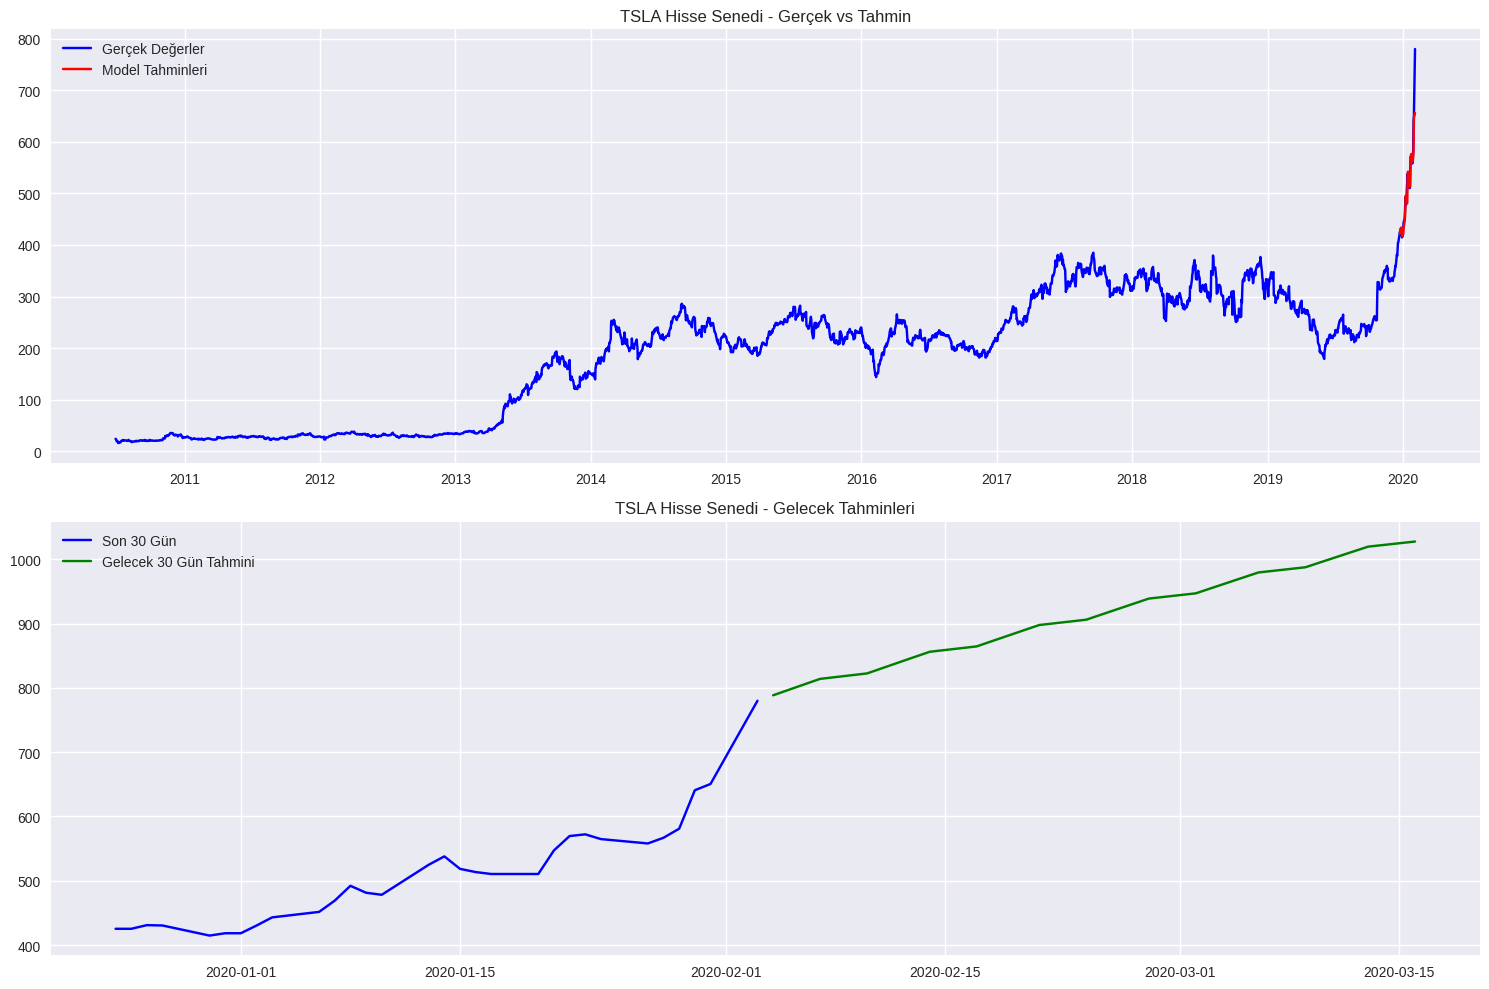

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Matplotlib ayarları
plt.style.use('seaborn-v0_8')  # Güncellenmiş stil ismi

# Veri yolunu belirle
DATA_PATH = '/kaggle/input/tsla-csv/TSLA.csv'

# Veriyi okuma ve hazırlama
def prepare_data(df):
    # Tarihi index olarak ayarla ve frekans bilgisi ekle
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df.asfreq('B')  # İş günü frekansını ayarla
    
    # Eksik değerleri doldur
    df['Adj Close'] = df['Adj Close'].fillna(method='ffill')
    
    return df['Adj Close']

def test_stationarity(timeseries):
    # Durağanlık testi
    result = adfuller(timeseries)
    print('ADF İstatistiği:', result[0])
    print('p-değeri:', result[1])
    print('Kritik değerler:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    # Durağanlık kontrolü
    if result[1] > 0.05:
        print("\nSeri durağan değil. Fark alma işlemi uygulanacak.")
        return False
    else:
        print("\nSeri durağan.")
        return True

def plot_analysis(data, predictions, forecast):
    plt.figure(figsize=(15, 10))
    
    # Gerçek değerler vs Tahminler
    plt.subplot(2, 1, 1)
    plt.plot(data.index, data, label='Gerçek Değerler', color='blue')
    plt.plot(predictions.index, predictions, label='Model Tahminleri', color='red')
    plt.title('TSLA Hisse Senedi - Gerçek vs Tahmin')
    plt.legend()
    
    # Gelecek tahminleri
    plt.subplot(2, 1, 2)
    plt.plot(data.index[-30:], data[-30:], label='Son 30 Gün', color='blue')
    plt.plot(forecast.index, forecast, label='Gelecek 30 Gün Tahmini', color='green')
    plt.title('TSLA Hisse Senedi - Gelecek Tahminleri')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def find_optimal_order(ts):
    # Basit grid search ile optimal p,d,q değerlerini bul
    best_aic = float('inf')
    best_order = None
    
    for p in range(0, 3):
        for d in range(0, 2):
            for q in range(0, 3):
                try:
                    model = ARIMA(ts, order=(p,d,q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p,d,q)
                except:
                    continue
    
    print(f"En iyi ARIMA parametreleri (p,d,q): {best_order}")
    return best_order

def analyze_stock(data):
    # Veriyi hazırla
    ts = prepare_data(data)
    
    # Durağanlık testi
    print("Durağanlık Testi Sonuçları:")
    is_stationary = test_stationarity(ts)
    
    # Optimal ARIMA parametrelerini bul
    optimal_order = find_optimal_order(ts)
    
    # ARIMA modelini oluştur
    model = ARIMA(ts, order=optimal_order)
    results = model.fit()
    
    # Model özeti
    print("\nModel Özeti:")
    print(results.summary())
    
    # Tahminler
    predictions = results.predict(start=len(ts)-30, end=len(ts)-1, dynamic=False)
    
    # Gelecek tahminleri
    future_dates = pd.date_range(start=ts.index[-1], periods=31, freq='B')[1:]
    forecast = results.forecast(steps=30)
    forecast.index = future_dates
    
    # Hata metrikleri
    mse = mean_squared_error(ts[-30:], predictions)
    rmse = np.sqrt(mse)
    print(f"\nRMSE: {rmse:.2f}")
    
    # Görselleştirme
    plot_analysis(ts, predictions, forecast)
    
    return results, predictions, forecast

# Veriyi oku ve analizi çalıştır
print("Veri okunuyor ve analiz başlıyor...")
df = pd.read_csv(DATA_PATH)
results, predictions, forecast = analyze_stock(df)

**hiperparametre optimizasyonu**

Veri okunuyor ve analiz başlıyor...
Durağanlık Testi Sonuçları:
ADF İstatistiği: 1.4450808272357065
p-değeri: 0.9973096161621413
Kritik değerler:
	1%: -3.433
	5%: -2.863
	10%: -2.567

Seri durağan değil. Fark alınmış seri kullanılacak.
Hiperparametre optimizasyonu başlıyor...
İlerleme: 5/48 (10.4%)
İlerleme: 10/48 (20.8%)
İlerleme: 15/48 (31.2%)
İlerleme: 20/48 (41.7%)
İlerleme: 25/48 (52.1%)
İlerleme: 30/48 (62.5%)
İlerleme: 35/48 (72.9%)
İlerleme: 40/48 (83.3%)
İlerleme: 45/48 (93.8%)

En iyi 5 model:
        order           AIC           BIC       RMSE       MAE  MAPE
43  (3, 1, 3)  11986.778430  12025.991744  12.151482  7.366840   inf
26  (2, 0, 2)  11989.575234  12023.189642  12.150072  7.367942   inf
0   (0, 0, 0)  11990.302023  12001.506826  12.151383  7.367769   inf
14  (1, 0, 2)  11990.678343  12018.690350  12.151242  7.367927   inf
25  (2, 0, 1)  11990.718873  12018.730879  12.151242  7.367901   inf

Seçilen optimal parametreler (p,d,q): (3, 1, 3)

Test Seti Hata Metrikleri:


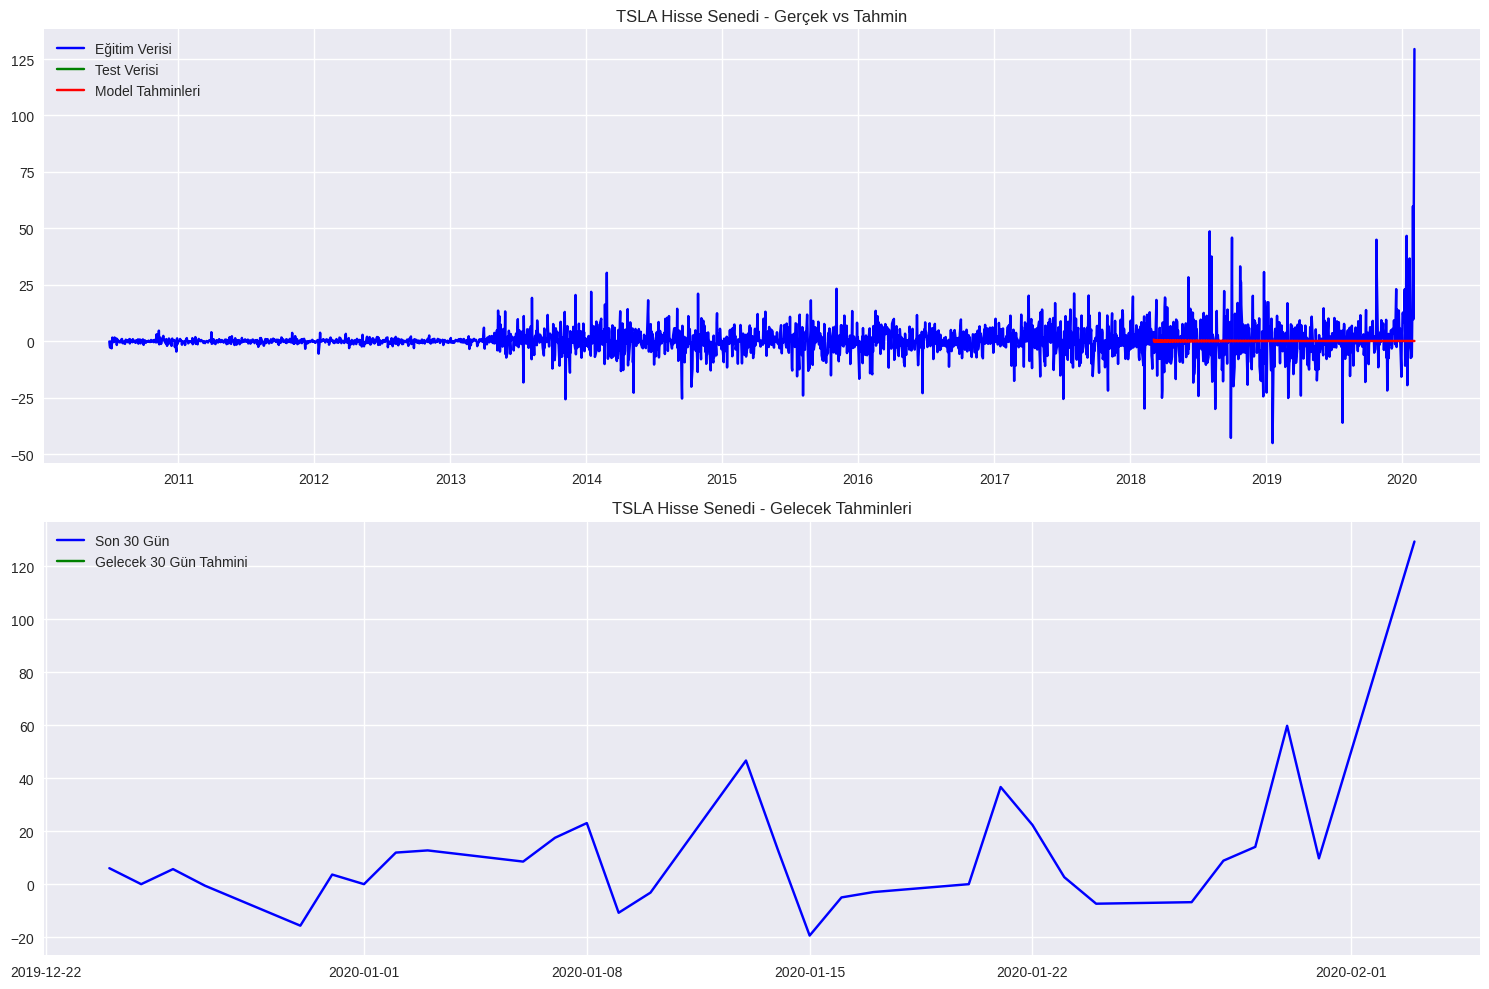

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import itertools
import warnings
warnings.filterwarnings('ignore')

# Veri yolunu belirle
DATA_PATH = '/kaggle/input/tsla-csv/TSLA.csv'

def prepare_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df.asfreq('B')
    return df['Adj Close'].fillna(method='ffill')

def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF İstatistiği:', result[0])
    print('p-değeri:', result[1])
    print('Kritik değerler:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result[1] <= 0.05

def calculate_metrics(y_true, y_pred):
    """Farklı hata metriklerini hesapla"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

def optimize_arima_parameters(ts, train_size=0.8):
    """
    Grid search ile optimal ARIMA parametrelerini bul
    """
    # Veriyi train ve test olarak böl
    train_size = int(len(ts) * train_size)
    train = ts[:train_size]
    test = ts[train_size:]
    
    # Grid search parametreleri
    p_values = range(0, 4)  # AR parametreleri
    d_values = range(0, 3)  # Fark alma derecesi
    q_values = range(0, 4)  # MA parametreleri
    
    best_score = float('inf')
    best_params = None
    best_model = None
    results = []
    
    print("Hiperparametre optimizasyonu başlıyor...")
    total_combinations = len(list(itertools.product(p_values, d_values, q_values)))
    current = 0
    
    for p, d, q in itertools.product(p_values, d_values, q_values):
        current += 1
        try:
            # Model eğitimi
            model = ARIMA(train, order=(p, d, q))
            model_fit = model.fit()
            
            # Tahminler
            predictions = model_fit.forecast(steps=len(test))
            
            # Metrikler
            metrics = calculate_metrics(test, predictions)
            aic = model_fit.aic
            bic = model_fit.bic
            
            results.append({
                'order': (p, d, q),
                'AIC': aic,
                'BIC': bic,
                **metrics
            })
            
            # En iyi modeli güncelle (AIC + RMSE karışımı)
            combined_score = aic + metrics['RMSE']
            if combined_score < best_score:
                best_score = combined_score
                best_params = (p, d, q)
                best_model = model_fit
            
            # İlerleme durumu
            if current % 5 == 0:
                print(f"İlerleme: {current}/{total_combinations} "
                      f"({(current/total_combinations*100):.1f}%)")
        
        except:
            continue
    
    # Sonuçları DataFrame'e dönüştür
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('AIC')
    
    print("\nEn iyi 5 model:")
    print(results_df.head())
    
    print(f"\nSeçilen optimal parametreler (p,d,q): {best_params}")
    return best_params, best_model, results_df

def plot_analysis(data, predictions, forecast, train_size=0.8):
    plt.figure(figsize=(15, 10))
    
    # Gerçek değerler vs Tahminler
    plt.subplot(2, 1, 1)
    train_size = int(len(data) * train_size)
    
    plt.plot(data.index[:train_size], data[:train_size], 
             label='Eğitim Verisi', color='blue')
    plt.plot(data.index[train_size:], data[train_size:], 
             label='Test Verisi', color='green')
    plt.plot(predictions.index, predictions, 
             label='Model Tahminleri', color='red')
    plt.title('TSLA Hisse Senedi - Gerçek vs Tahmin')
    plt.legend()
    
    # Gelecek tahminleri
    plt.subplot(2, 1, 2)
    plt.plot(data.index[-30:], data[-30:], 
             label='Son 30 Gün', color='blue')
    plt.plot(forecast.index, forecast, 
             label='Gelecek 30 Gün Tahmini', color='green')
    plt.title('TSLA Hisse Senedi - Gelecek Tahminleri')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def analyze_stock(data, train_size=0.8):
    # Veriyi hazırla
    ts = prepare_data(data)
    
    # Durağanlık testi
    print("Durağanlık Testi Sonuçları:")
    is_stationary = test_stationarity(ts)
    
    if not is_stationary:
        print("\nSeri durağan değil. Fark alınmış seri kullanılacak.")
        ts = ts.diff().dropna()
    
    # Optimal parametreleri bul
    best_params, best_model, results_df = optimize_arima_parameters(ts, train_size)
    
    # Tahminler
    train_size = int(len(ts) * train_size)
    predictions = best_model.predict(start=train_size, end=len(ts)-1)
    
    # Gelecek tahminleri
    future_dates = pd.date_range(start=ts.index[-1], periods=31, freq='B')[1:]
    forecast = best_model.forecast(steps=30)
    forecast = pd.Series(forecast, index=future_dates)
    
    # Hata metrikleri
    metrics = calculate_metrics(ts[train_size:], predictions)
    print("\nTest Seti Hata Metrikleri:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")
    
    # Görselleştirme
    plot_analysis(ts, predictions, forecast, train_size)
    
    return best_model, predictions, forecast, results_df

# Veriyi oku ve analizi çalıştır
print("Veri okunuyor ve analiz başlıyor...")
df = pd.read_csv(DATA_PATH)
model, predictions, forecast, results = analyze_stock(df)